In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from __future__ import print_function
from pixell import enmap
import numpy as np
import matplotlib.pyplot as plt
from pixell import enplot
import scipy
import pymaster as nmt

In [3]:
import data.from_choi.kfilter.kfilter_share as kfilter

# File Loading and Plotting

In [4]:
lmax_beam = 30000
nsplits = 4

apopath = 'data/from_choi/apo_mask/deep56_c7v5_car_190220_rect_master_apo_w0.fits'
apo = enmap.read_map(apopath)
box = enmap.box(apo.shape,apo.wcs)

# PA 1 -----
beam_filename = "data/from_choi/beam/beam_tform_160201_s14_pa1_f150_jitter_CMB_deep56.txt"
mapname_head = "data/from_choi/maps/ACTPol_148_D56_pa1_f150_s14_4way_split"
raw_maps = [enmap.read_map(f"{mapname_head}{i}_srcadd_I.fits") for i in range(nsplits)]

mask = enmap.read_fits("data/from_choi/window/deep56_s14_pa1_f150_c7v5_car_190220_rect_w0_cl0.00nK_pt1.00_nt0.0_T.fits")
mask = mask.submap(box, mode='round')
beam_table = np.loadtxt(beam_filename)

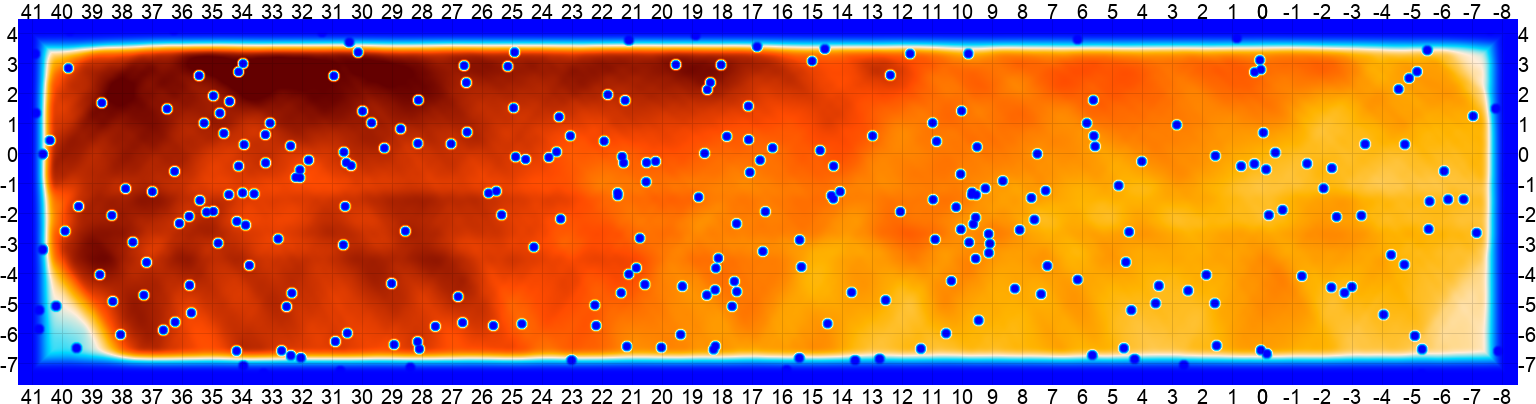

In [5]:
plots = enplot.get_plots(mask, downgrade=4)
enplot.show(plots)

In [6]:
kx = 90
ky = 50
kx_apo = 0
ky_apo = 0
unpixwin = 1
d_th = 1/120.

boxed_maps = [rm.submap(box, mode='round') for rm in raw_maps]
maps = [enmap.samewcs(
            kfilter.get_map_kx_ky_filtered_pyfftw(
                apo*m,d_th,kx,kx_apo,ky,ky_apo,unpixwin=unpixwin,zero_pad=False),
            m) 
    for m in boxed_maps]

## Map

We show the unfiltered map, and the k-space filtered map.

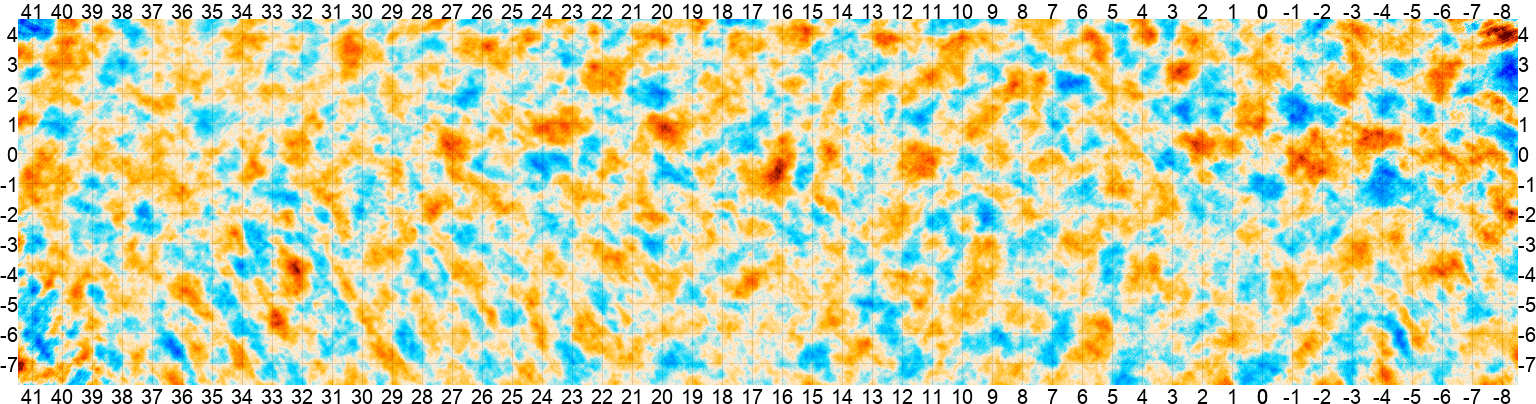

In [7]:
plots = enplot.get_plots(boxed_maps[0], range=1000, downgrade=4)
enplot.show(plots)

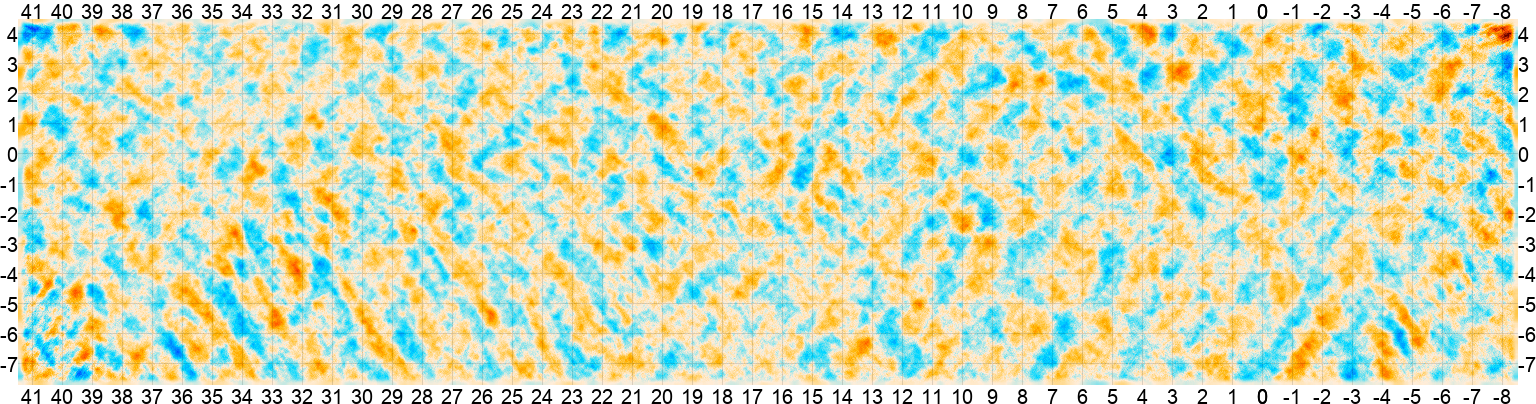

In [8]:
plots = enplot.get_plots(maps[0], range=1000, downgrade=4)
enplot.show(plots)

## Beam

Text(0, 0.5, '$B_{\\ell}$')

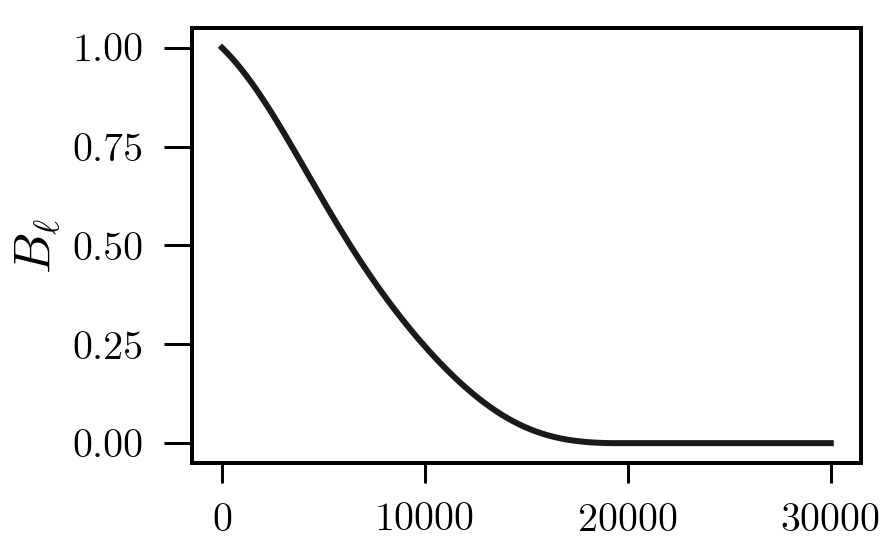

In [9]:
Bl = np.zeros(lmax_beam)
Bl[:beam_table.shape[0]] = beam_table[:,1].astype(float)
beam = Bl

plt.plot( np.arange(lmax_beam), beam)
plt.ylabel(r"$B_{\ell}$")

# Binning

In [10]:
binleft, binright, bincenter = np.loadtxt( 'data/from_choi/binning/BIN_ACTPOL_50_4_SC_low_ell', unpack=True, 
                                          dtype={'names': ('binleft', 'binright', 'bincenter'),
                                                 'formats': ('i', 'i', 'f')})
lmax = 7925
ells = np.arange(lmax)
bpws=-1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft[1:], binright[1:])):
    bpws[bl:br+1] = i
    
weights = np.array([1.0 / np.sum(bpws == bpws[l]) for l in range(lmax)])

In [12]:
b =nmt.NmtBin(2048,bpws=bpws,ells=ells,weights=weights, lmax=lmax)
lb = b.get_effective_ells()

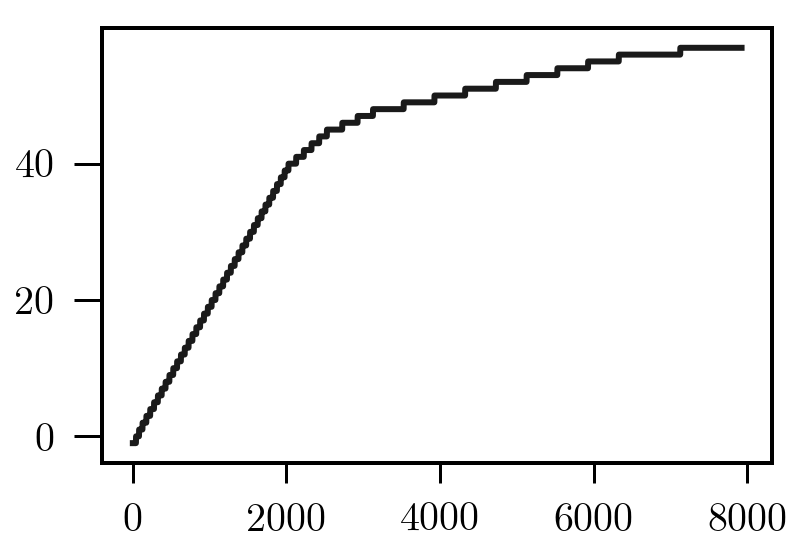

In [13]:
plt.plot(bpws)

# Power Spectra with NaMaster

## Quick Test
We compute the cross spectrum of splits 0 and 1.

In [14]:
niter = 0 # NaMaster-CAR only supports niter=0

field0 = nmt.NmtField(mask, [maps[0]], beam=beam, wcs=mask.wcs, n_iter=niter)
field1 = nmt.NmtField(mask, [maps[1]], beam=beam, wcs=mask.wcs, n_iter=niter)
cl_coupled = nmt.compute_coupled_cell(field0, field1)
lb = b.get_effective_ells()
w0 = nmt.NmtWorkspace()
w0.compute_coupling_matrix(field0,field1, b, n_iter=niter)
Cb = w0.decouple_cell(cl_coupled)

(0, 3000)

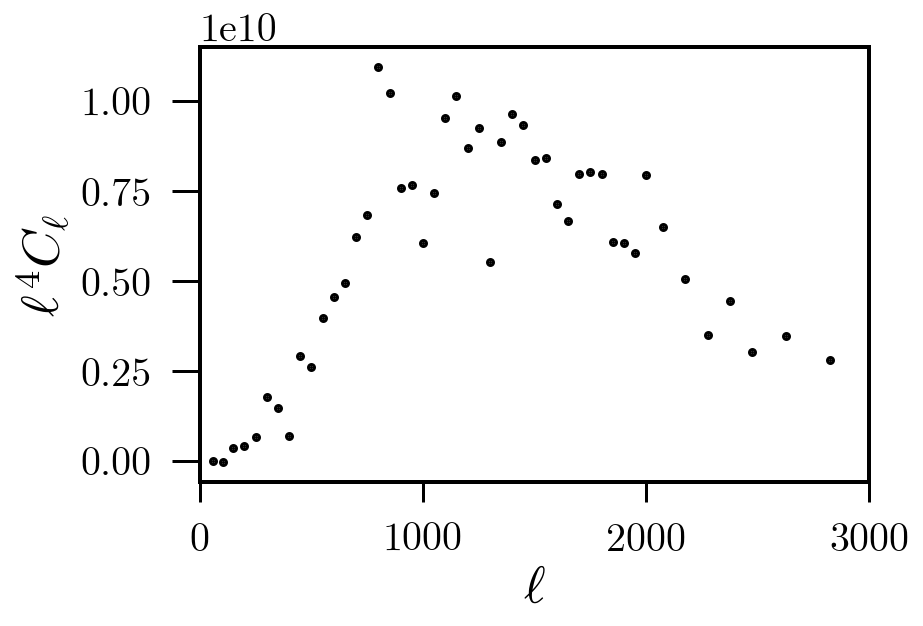

In [15]:
plt.plot( lb, Cb[0] * lb**4, 'k.' )
plt.ylabel(r"$\ell^4 C_{\ell}$")
plt.xlabel(r"$\ell$")
plt.xlim(0, 3000)
# plt.ylim(0, 35000)

## All Splits

In [16]:
ps_dict = {}
cross_spectra = []
fields = [nmt.NmtField(mask, [maps[i]], beam=beam, wcs=mask.wcs, n_iter=niter)
         for i in range(nsplits)]

# we can reuse the workspace w0 from earlier
for i in range(nsplits):
    for j in range(nsplits):
        if i > j:
            cl_coupled = nmt.compute_coupled_cell(fields[i], fields[j])
            Cb = w0.decouple_cell(cl_coupled)
            ps_dict[f"{i},{j}"] = Cb
            cross_spectra += [Cb[0]]

In [31]:
len(cross_spectra)

6

We can do a poor cosmologist's error bar by taking the standard errors of the cross spectra from the splits.

In [17]:
mean_Cltt = np.sum(cross_spectra, axis=0) / len(cross_spectra)
se_Cltt = np.std(cross_spectra, axis=0)/np.sqrt(len(cross_spectra))

(-100000000.0, 2500000000.0)

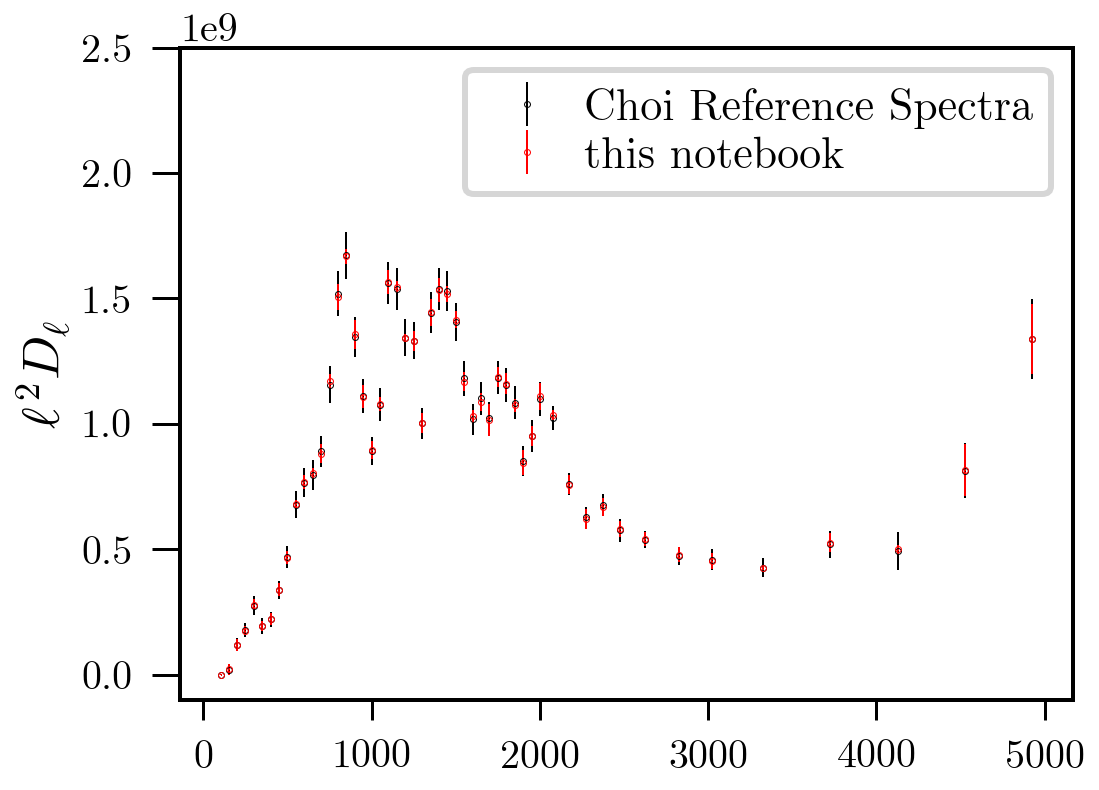

In [24]:
plt.figure(figsize=(8,6))

actual_cltt = np.loadtxt("data/from_choi/ps/deep56_s14_pa1_f150_c7v5_car_190220_rect_window0_TT_lmax7925_fsky0.01081284_output.txt")
choi_dl = actual_cltt[2:54,1]
choi_delta_dl = actual_cltt[2:54,2]
plt.errorbar( actual_cltt[2:54,0] , (choi_dl * actual_cltt[2:54,0]**2), 
             yerr = choi_delta_dl * actual_cltt[2:54,0]**2, fmt='k.', lw=1, ms=1, label="Choi Reference Spectra" )

lbs = lb[1:-3]
notebook_dl = mean_Cltt[1:-3]  * lbs * (lbs+1) / 2 / np.pi 
plt.errorbar(lbs, notebook_dl * lbs**2 , 
             fmt='r.', yerr=(se_Cltt)[1:-3] * lbs * (lbs+1) / 2 / np.pi * lbs**2 ,
             lw=1, ms=1, label="this notebook")
plt.ylabel(r"$\ell^2 D_{\ell}$")
plt.legend(frameon=True)
# plt.xlim(0,2800)
# plt.xscale("log")
plt.ylim(-1e8, 2.5e9)

Text(0.5, 1.0, 'notebook / Choi')

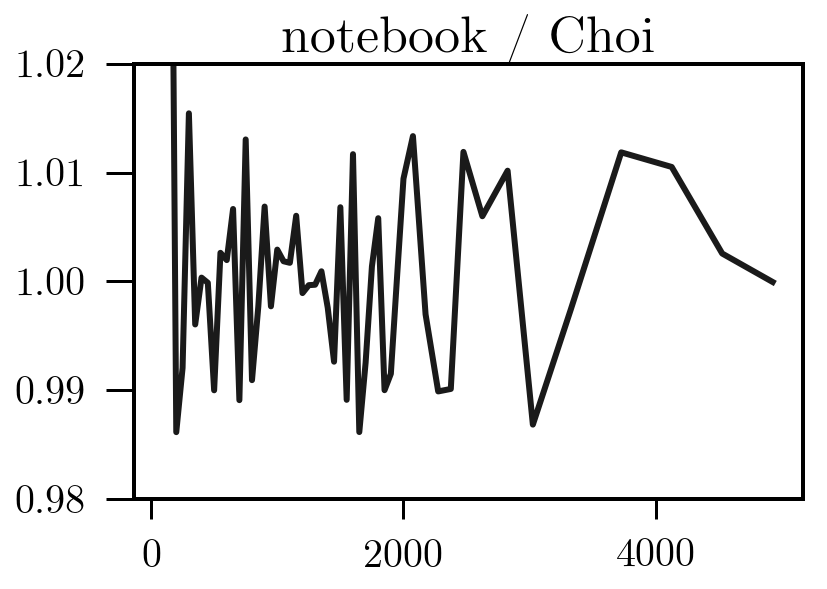

In [25]:
plt.plot( lbs, notebook_dl / choi_dl )
plt.ylim(0.98, 1.02)
plt.title("notebook / Choi")

Text(0.5, 1.0, '$\\Delta$PS  / Choi noise')

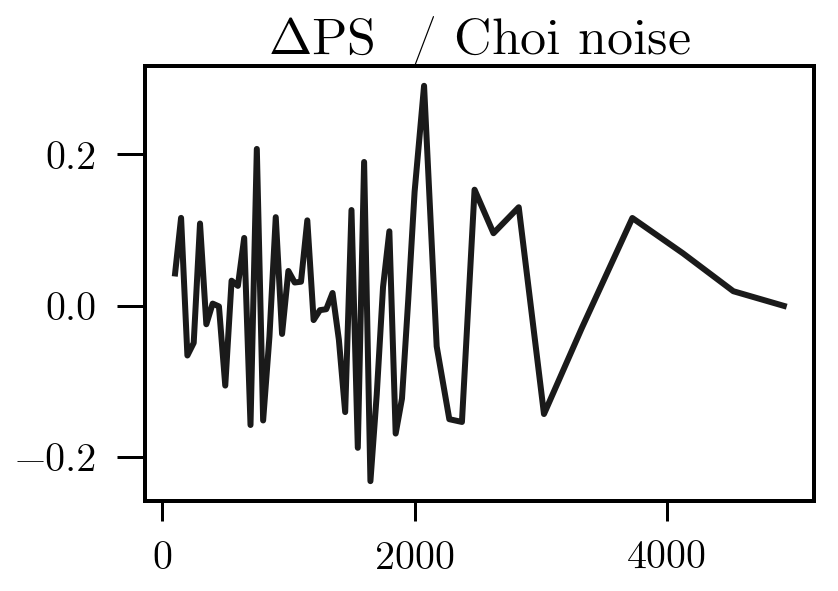

In [30]:
plt.plot( lbs, (notebook_dl - choi_dl) / choi_delta_dl )
plt.title("$\Delta$PS  / Choi noise")